In [1]:
#pip install tf-nightly

In [2]:
#pip install keras --upgrade

In [3]:
#pip install psutil

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import psutil
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold

print(tf.__version__)

2.3.0-dev20200624


In [5]:
# Naming variable
NAME = "20200701-Image-ENB3-5FoldCV-10Epochs-TL"

# Paths to files
SAVE_DIR = './saved_models/'
WEIGHTS_FILEPATH = './trained_weights/cnn/'

# Function to save and load weights
def get_weights(fold_var=0):
    return NAME+'_'+str(fold_var)+'.h5'

#### Load, resize, rescale and check image data

In [6]:
# Pre-processed data files
X_train_load = pd.read_csv('./cleaned_csvs/train_pp.csv')
X_test_load = pd.read_csv('./cleaned_csvs/test_pp.csv')

# Create copies of tabular data for image pre-processing
X_train_pp = X_train_load.copy()
X_test_pp = X_test_load.copy()

# Separate target from predictors
y_train = X_train_pp.target
X_train_pp.drop(['target'], axis=1, inplace=True)
targets = np.array(y_train, dtype="uint8")

# Create lists of the image names for parsing on import
X_train_img = X_train_load['image_name']
X_test_img = X_test_load['image_name']

#Create path to images for import
img_folder_train = './siim-isic-melanoma-classification/jpeg/train/'
img_folder_test = './siim-isic-melanoma-classification/jpeg/test/'

# Define required image size and batch size for feeding to model
IMAGE_SIZE = 224
BATCH_SIZE = 64
TEST_BATCH_SIZE = 2

In [7]:
print(f'Number of Training Examples = {X_train_pp.shape[0]}')
print(f'Number of Test Examples = {X_test_pp.shape[0]}\n')

print("y_train.shape:", y_train.shape)

Number of Training Examples = 33126
Number of Test Examples = 10982

y_train.shape: (33126,)


In [8]:
# Skip the next two steps if loading pre-resized npy file
X_train_np = np.load(f'./npy_files/X_train_jpg_{IMAGE_SIZE}.npy')

In [9]:
# Import and resize (remember cv2 imports as BGR, not RGB)
# X_train = []
# for image_get in tqdm(X_train_img):
#     img_train = cv2.imread(img_folder_train + '{}.jpg'.format(image_get))
#     img_train = cv2.resize(img_train,(IMAGE_SIZE,IMAGE_SIZE))
#     img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
#     X_train.append(img_train)

In [10]:
# # convert to numpy array
# X_train_np = np.array(X_train)
# # save to npy file
# np.save(f'./npy_files/X_train_jpg_{IMAGE_SIZE}.npy', X_train_np)

Size of X_train_np is:  (33126, 224, 224, 3)


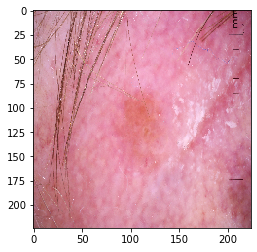

In [11]:
print("Size of X_train_np is: ", X_train_np.shape)
plt.imshow(X_train_np[0])
plt.show()

In [12]:
# Skip the next two steps if loading pre-resized npy file
X_test_np = np.load(f'./npy_files/X_test_jpg_{IMAGE_SIZE}.npy')   

In [13]:
# # Import and resize (remember cv2 imports as BGR, not RGB)
# X_test = []
# for image_get in tqdm(X_test_img):
#     img_test = cv2.imread(img_folder_test + '{}.jpg'.format(image_get))
#     img_test = cv2.resize(img_test,(IMAGE_SIZE,IMAGE_SIZE))
#     img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
#     X_test.append(img_test)

In [14]:
# # convert to numpy array
# X_test_np = np.array(X_test)
# # save to npy file
# np.save(f'./npy_files/X_test_jpg_{IMAGE_SIZE}.npy', X_test_np)

Size of X_test_np is:  (10982, 224, 224, 3)


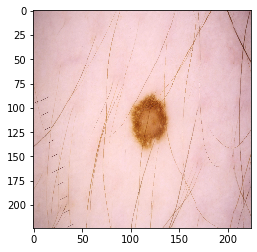

In [15]:
print("Size of X_test_np is: ", X_test_np.shape)
plt.imshow((X_test_np[1]))
plt.show()

#### Build the cross-validation model

In [16]:
# Limit the amount of data whilst testing code
# lim = int(BATCH_SIZE*300/0.8)
lim = 33126
print("Number of samples: ",lim)
X_train_np = X_train_np[:lim]
targets = targets[:lim]

Number of samples:  33126


In [17]:
# Function to generate cross validation datasets
def generate_fold_dataset(X_train_np, targets, train_index, val_index):
    X_train, X_val = X_train_np[train_index], X_train_np[val_index]
    y_train, y_val = targets[train_index], targets[val_index]
    return X_train, X_val, y_train, y_val

In [18]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [19]:
# Model function
def ENB3_Model(train_dataset, val_dataset):
    print("RAM percentage used at beginning of model before session clear: ", psutil.virtual_memory().percent)
    keras.backend.clear_session() #IMPORTANT TO AVOID MEMORY LEAKAGE
    print("RAM percentage used at beginning of model after session clear: ", psutil.virtual_memory().percent)

    # MODEL
    
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # First, instantiate a base model with pre-trained weights from ImageNet.
    # Do not include the ImageNet classifier. Top off the model with Sigmoid instead.
    base_model = keras.applications.EfficientNetB3(weights='imagenet',
                                                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                   include_top=False)  
    
    # Then, freeze the base model.
    base_model.trainable = False #This means we don't update the imagenet parameters.
    
    # We make sure that the base_model is running in inference (not training) mode here,
    x = base_model(inputs, training=False)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(128, activation='relu')(x)

    # A Dense header with a single unit (binary classification)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    cnn_model = keras.Model(inputs, outputs)

    # Learning Rate Scheduler
    lrfn = build_lrfn()
    lr_schedule = keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    # CREATE CALLBACKS AND METRICS
    callbacks_list = [lr_schedule,
                      ModelCheckpoint(WEIGHTS_FILEPATH+get_weights(fold_var)),
                      ModelCheckpoint(
                                filepath=WEIGHTS_FILEPATH+'best_'+get_weights(fold_var),
                                save_best_only=True,  # Only save a model if `val_auc` has improved.
                                monitor='val_auc',
                                mode='max',
                                verbose=0,
                                )]
 
    metrics = [keras.metrics.AUC(name="auc")]

    # COMPILE MODEL
    cnn_model.compile(optimizer=Adam(),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      metrics=metrics)

    cnn_model.summary()
    
    # FIT THE MODEL
    history_cnn = cnn_model.fit(train_dataset,
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        verbose=1,
                        validation_data=val_dataset,
                        callbacks=callbacks_list
                       )
    
    # Use fit history
    AUC = history_cnn.history['auc']
    VAL_AUC = history_cnn.history['val_auc']
    LOSS = history_cnn.history['loss']
    VAL_LOSS = history_cnn.history['val_loss']
   
    print("RAM percentage used at end of model: ", psutil.virtual_memory().percent)
    
    # Save the model
    cnn_model.save(SAVE_DIR+NAME+'_'+str(fold_var)+'.h5')
    
    return AUC, VAL_AUC, LOSS, VAL_LOSS

In [20]:
VALIDATION_AUC = []
VALIDATION_LOSS = []
TRAIN_AUC = []
TRAIN_LOSS = []

FOLDS = 5

NUM_EPOCHS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
fold_var = 1

for train_index, val_index in skf.split(X_train_np, targets):
    keras.backend.clear_session() #IMPORTANT TO AVOID MEMORY LEAKAGE
    print("Fold number: ", fold_var)
    print("RAM percentage used at beginning of loop process: ", psutil.virtual_memory().percent)
    
    # GENERATE FOLD DATASET
    X_train, X_val, y_train, y_val = generate_fold_dataset(X_train_np, targets, train_index, val_index)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    train_dataset = train_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    
    #MODEL
    AUC, VAL_AUC, LOSS, VAL_LOSS = ENB3_Model(train_dataset, val_dataset)
    
    TRAIN_AUC.append(AUC)
    TRAIN_LOSS.append(LOSS) 
    VALIDATION_AUC.append(VAL_AUC)
    VALIDATION_LOSS.append(VAL_LOSS)   

    gc.collect()
    print("RAM percentage used at end of loop process: ", psutil.virtual_memory().percent)    
    
    # Increase fold count variable
    fold_var += 1

Fold number:  1
RAM percentage used at beginning of loop process:  15.5
RAM percentage used at beginning of model before session clear:  31.1
RAM percentage used at beginning of model after session clear:  31.1
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
415/415 [==============================] - 51s 123ms/step - loss: 0.1199 - auc: 0.5816 - val_loss: 0.0828 - val_auc: 0.7304

Epoch 00002: LearningRateScheduler reducing learning rate to 1.45e-05.
Epoch 2/10
415/415 [==============================] - 50s 120ms/step - loss: 0.0796 - auc: 0.7674 - val_loss: 0.0759 - val_auc: 0.8219

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/10
415/415 [==============================] - 50s 120ms/step - loss: 0.0745 - auc: 0.8241 - val_loss: 0.0727 - val_auc: 0.8461

Epoch 00004: LearningRateScheduler reducing learning rate to 2.3500000000000002e-05.
Epoch 4/10
415/415 [==============================] - 50s 120ms/step - loss: 0.0711 - auc: 0.8512 - val_loss: 0.0712 - val_auc: 0.8592

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
Epoch 5/10
415/415 [==============================] - 50s 121ms/step - loss:


Epoch 00006: LearningRateScheduler reducing learning rate to 3.2500000000000004e-05.
Epoch 6/10
415/415 [==============================] - 50s 121ms/step - loss: 0.0666 - auc: 0.8812 - val_loss: 0.0726 - val_auc: 0.8324

Epoch 00007: LearningRateScheduler reducing learning rate to 3.7e-05.
Epoch 7/10
415/415 [==============================] - 50s 121ms/step - loss: 0.0641 - auc: 0.8929 - val_loss: 0.0717 - val_auc: 0.8376

Epoch 00008: LearningRateScheduler reducing learning rate to 4.15e-05.
Epoch 8/10
415/415 [==============================] - 50s 121ms/step - loss: 0.0615 - auc: 0.9056 - val_loss: 0.0710 - val_auc: 0.8426

Epoch 00009: LearningRateScheduler reducing learning rate to 4.6e-05.
Epoch 9/10
415/415 [==============================] - 50s 121ms/step - loss: 0.0588 - auc: 0.9158 - val_loss: 0.0704 - val_auc: 0.8494

Epoch 00010: LearningRateScheduler reducing learning rate to 5.05e-05.
Epoch 10/10
415/415 [==============================] - 50s 120ms/step - loss: 0.0560 - a

In [21]:
auc_list = [np.mean(l) for l in np.array(TRAIN_AUC).T]
loss_list = [np.mean(l) for l in np.array(TRAIN_LOSS).T]
val_auc_list = [np.mean(l) for l in np.array(VALIDATION_AUC).T]
val_loss_list = [np.mean(l) for l in np.array(VALIDATION_LOSS).T]
epochs = range(1, NUM_EPOCHS+1)

best_auc_val = max(val_auc_list)
best_epoch = val_auc_list.index(best_auc_val)+1

print(f"Best AUC Validation score of {best_auc_val} at epoch {best_epoch}.")
print(f"Expected Kaggle Public Leaderboard Score of {best_auc_val-0.02} at epoch {best_epoch} of training data.")

Best AUC Validation score of 0.8576678514480591 at epoch 9.


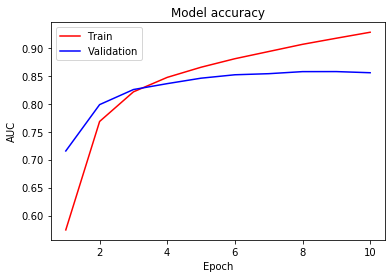

In [22]:
# Plot training & validation accuracy values
plt.plot(epochs, auc_list, 'r')
plt.plot(epochs, val_auc_list, 'b')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Train full dataset for final model

In [27]:
# Model function
def ENB3_Model_full(train_dataset):
    print("RAM percentage used at beginning of model before session clear: ", psutil.virtual_memory().percent)
    keras.backend.clear_session() #IMPORTANT TO AVOID MEMORY LEAKAGE
    print("RAM percentage used at beginning of model after session clear: ", psutil.virtual_memory().percent)
    
    # MODEL
    
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # First, instantiate a base model with pre-trained weights from ImageNet.
    # Do not include the ImageNet classifier. Top off the model with Sigmoid instead.
    base_model = keras.applications.EfficientNetB3(weights='imagenet',
                                                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                   include_top=False)  
    
    # Then, freeze the base model.
    base_model.trainable = False #This means we don't update the imagenet parameters.
    
    # We make sure that the base_model is running in inference (not training) mode here,
    x = base_model(inputs, training=False)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(128, activation='relu')(x)

    # A Dense header with a single unit (binary classification)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    cnn_model = keras.Model(inputs, outputs)

    # Learning Rate Scheduler
    lrfn = build_lrfn()
    lr_schedule = keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    # CREATE CALLBACKS AND METRICS
    callbacks_list = [ModelCheckpoint(WEIGHTS_FILEPATH+NAME+'_at_epoch{epoch}.h5'),
                      lr_schedule]
    metrics = [keras.metrics.AUC(name="auc")]

    # COMPILE MODEL
    cnn_model.compile(optimizer=Adam(),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      metrics=metrics)

    cnn_model.summary()
    
    # FIT THE MODEL
    history_cnn = cnn_model.fit(train_dataset,
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        verbose=1,
                        callbacks=callbacks_list
                       )
    
    # Use fit history
    AUC = history_cnn.history['auc']
    LOSS = history_cnn.history['loss']
   
    print("RAM percentage used at end of model: ", psutil.virtual_memory().percent)
    
    # Save the model
    cnn_model.save(SAVE_DIR+NAME+'-FULL.h5')
    
    return AUC, LOSS

In [28]:
NUM_EPOCHS = 10
fold_var = 0

train_dataset_full = tf.data.Dataset.from_tensor_slices((X_train_np, targets))
train_dataset_full = train_dataset_full.batch(BATCH_SIZE)
    
AUC, LOSS = ENB3_Model_full(train_dataset_full)

RAM percentage used at beginning of model before session clear:  57.8
RAM percentage used at beginning of model after session clear:  57.8
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)         

In [29]:
AUC

[0.6090846061706543,
 0.8034225702285767,
 0.8399301767349243,
 0.8569019436836243,
 0.8746291399002075,
 0.8883175849914551,
 0.9010414481163025,
 0.9115212559700012,
 0.9216787219047546,
 0.9319531917572021]

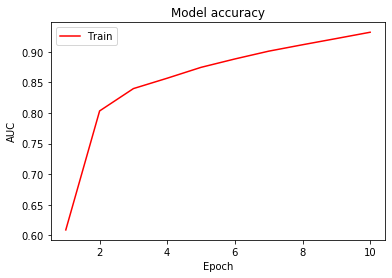

In [30]:
# Plot training & validation accuracy values
epochs = range(1, NUM_EPOCHS+1)

plt.plot(epochs, AUC, 'r')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

#### Generate predictions

In [32]:
# Load model and weights of best validation score epoch in CV model
predict_model = keras.models.load_model(SAVE_DIR+NAME+'-FULL.h5')
predict_model.load_weights(WEIGHTS_FILEPATH+NAME+'_at_epoch9.h5')

# Create TF Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(X_test_np)

# Predict
preds_test=predict_model.predict(test_dataset,verbose=1)

10982/10982 [==============================] - 178s 16ms/step


In [33]:
preds_test.shape

(10982, 1)

In [34]:
preds_test[0:10]

array([[0.0037158 ],
       [0.00284493],
       [0.00024432],
       [0.00021522],
       [0.01214206],
       [0.00336544],
       [0.00236898],
       [0.00741146],
       [0.00618067],
       [0.01611283]], dtype=float32)

In [35]:
# Use .ravel() to flatten from 10982,1 to 10982,
output = pd.DataFrame({'image_name': X_test_load.image_name,
                       'target': preds_test.ravel()})
output.to_csv('./predictions/'+NAME+'.csv', index=False)

In [36]:
output.head()

,image_name,target
0,ISIC_0052060,0.003716
1,ISIC_0052349,0.002845
2,ISIC_0058510,0.000244
3,ISIC_0073313,0.000215
4,ISIC_0073502,0.012142
